In [2]:
import pandas as pd
import numpy as np
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
patients = pd.read_csv('ExamplePats.csv')
patients.head()

,pnr,eksd,perday,ATC,dur_original
0,1,2033-04-26,4,medA,50
1,1,2033-07-04,4,medB,30
2,1,2033-08-03,4,medB,30
3,1,2033-08-17,4,medB,30
4,1,2033-10-13,4,medB,30


In [4]:
patients['eksd'] =pd.to_datetime(patients['eksd'])
print(patients.dtypes)
patients.head()

pnr                      int64
eksd            datetime64[ns]
perday                   int64
ATC                     object
dur_original             int64
dtype: object


,pnr,eksd,perday,ATC,dur_original
0,1,2033-04-26,4,medA,50
1,1,2033-07-04,4,medB,30
2,1,2033-08-03,4,medB,30
3,1,2033-08-17,4,medB,30
4,1,2033-10-13,4,medB,30


In [5]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import gaussian_kde
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from itertools import product

def see(arg1, tidy):
    """
    Sessi Empirical Estimator implementation
    
    Parameters:
    arg1: str - ATC code to filter the data
    tidy: pandas DataFrame - Input dataset with columns: ATC, pnr, eksd
    
    Returns:
    pandas DataFrame - Processed data with duration estimates
    """
    # Filter data for specific ATC code
    c09ca01 = tidy[tidy['ATC'] == arg1].copy()
    
    # Create copy for different processing stages
    drug_see_p0 = c09ca01.copy()
    drug_see_p1 = c09ca01.copy()
    
    # Sort and calculate previous dates
    drug_see_p1 = drug_see_p1.sort_values(['pnr', 'eksd'])
    drug_see_p1['prev_eksd'] = drug_see_p1.groupby('pnr')['eksd'].shift(1)
    
    # Remove rows with NA previous dates
    drug_see_p1 = drug_see_p1.dropna(subset=['prev_eksd'])
    
    # Take random sample for each patient
    drug_see_p1 = drug_see_p1.groupby('pnr').apply(
        lambda x: x.iloc[np.random.randint(len(x))]
    ).reset_index(drop=True)
    
    # Keep only needed columns
    drug_see_p1 = drug_see_p1[['pnr', 'eksd', 'prev_eksd']]
    
    # Calculate interval
    drug_see_p1['event_interval'] = (
        drug_see_p1['eksd'] - drug_see_p1['prev_eksd']
    ).dt.total_seconds() / (24 * 60 * 60)  # Convert to days
    
    # Generate ECDF
    sorted_intervals = np.sort(drug_see_p1['event_interval'])
    ecdf = stats.ecdf(sorted_intervals)
    x = ecdf.x
    y = ecdf.y
    
    # Create DataFrame for ECDF
    dfper = pd.DataFrame({'x': x, 'y': y})
    
    # Retain the bottom 80% of ECDF
    dfper = dfper[dfper['y'] <= 0.8]
    
    # Plot ECDFs
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.plot(dfper['x'], dfper['y'])
    ax1.set_title('80% ECDF')
    ax2.plot(x, y)
    ax2.set_title('100% ECDF')
    plt.show()
    
    # Filter data based on maximum interval
    ni = dfper['x'].max()
    drug_see_p2 = drug_see_p1[drug_see_p1['event_interval'] <= ni]
    
    # Calculate density of log intervals
    kde = gaussian_kde(np.log(drug_see_p2['event_interval']))
    x1 = np.linspace(min(np.log(drug_see_p2['event_interval'])), 
                     max(np.log(drug_see_p2['event_interval'])), 100)
    y1 = kde.evaluate(x1)
    
    # Scale data
    a = np.column_stack((x1, y1))
    a = stats.zscore(a)
    
    # Find optimal number of clusters using silhouette score
    np.random.seed(1234)
    silhouette_scores = []
    K = range(2, 10)
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=1234)
        kmeans.fit(a)
        score = silhouette_score(a, kmeans.labels_)
        silhouette_scores.append(score)
    
    max_cluster = K[np.argmax(silhouette_scores)]
    
    # Perform K-means clustering
    np.random.seed(1234)
    cluster = KMeans(n_clusters=max_cluster, random_state=1234)
    dfper['cluster'] = cluster.fit_predict(dfper[['x']].values)
    
    # Calculate cluster statistics
    cluster_stats = dfper.groupby('cluster').agg({
        'x': ['min', 'max', 'median']
    }).reset_index()
    
    cluster_stats.columns = ['Cluster', 'Minimum', 'Maximum', 'Median']
    cluster_stats = cluster_stats[cluster_stats['Median'] > 0]
    
    # Create results DataFrame
    results = pd.DataFrame(list(product(drug_see_p1['pnr'], cluster_stats.itertuples(index=False))),
                          columns=['pnr', 'cluster_data'])
    
    results['Cluster'] = results['cluster_data'].apply(lambda x: x.Cluster)
    results['Median'] = results['cluster_data'].apply(lambda x: x.Median)
    results = results.drop('cluster_data', axis=1)
    
    # Find most frequent cluster
    t1 = pd.DataFrame({'Cluster': [results['Cluster'].mode().iloc[0]]})
    t1_merged = pd.merge(t1, results, on='Cluster').iloc[0:1]
    t1_merged = t1_merged[['pnr', 'Median']]
    
    # Merge results back
    drug_see_p1 = pd.merge(drug_see_p1, results, on='pnr', how='left')
    drug_see_p1['Median'] = drug_see_p1['Median'].fillna(t1_merged['Median'].iloc[0])
    drug_see_p1['Cluster'] = drug_see_p1['Cluster'].fillna('0')
    drug_see_p1['test'] = round(drug_see_p1['event_interval'] - drug_see_p1['Median'], 1)
    
    drug_see_p3 = drug_see_p1[['pnr', 'Median', 'Cluster']]
    
    # Assign Duration
    drug_see_p0 = pd.merge(drug_see_p0, drug_see_p3, on='pnr', how='left')
    drug_see_p0['Median'] = pd.to_numeric(drug_see_p0['Median'])
    drug_see_p0['Median'] = drug_see_p0['Median'].fillna(t1_merged['Median'].iloc[0])
    drug_see_p0['Cluster'] = drug_see_p0['Cluster'].fillna(0)
    
    return drug_see_p0

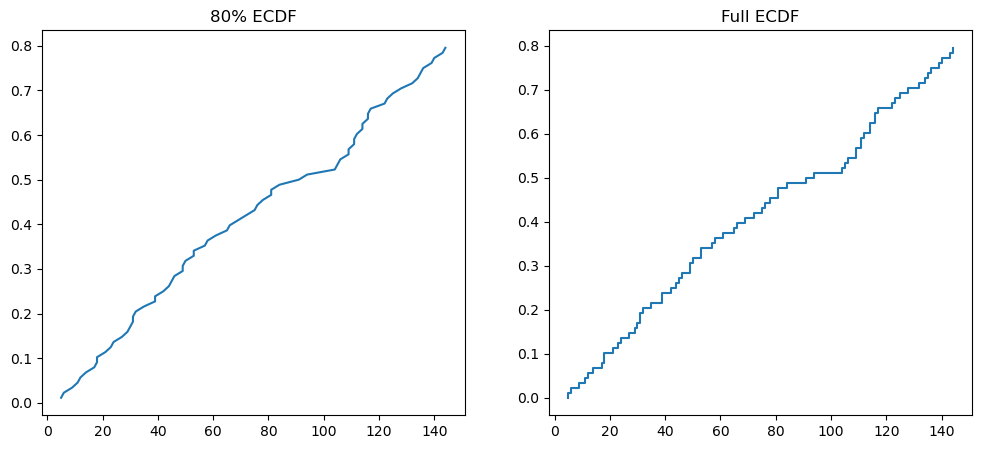

<class 'pandas.core.frame.DataFrame'>


ValueError: Input X contains infinity or a value too large for dtype('float64').

In [6]:
def see_function(arg1, df):
    # Filter by ATC code
    drug_df = df[df['ATC'] == arg1].copy()
    
    # Sort and calculate previous dates
    drug_df.sort_values(['pnr', 'eksd'], inplace=True)
    drug_df['prev_eksd'] = drug_df.groupby('pnr')['eksd'].shift(1)
    
    # Remove initial prescriptions and sample one per patient
    drug_p1 = drug_df.dropna(subset=['prev_eksd'])
    sampled = drug_p1.groupby('pnr').sample(n=1)
    sampled['event_interval'] = (sampled['eksd'] - sampled['prev_eksd']).dt.days
    
    return sampled

def calculate_ecdf(data):
    ecdf = ECDF(data['event_interval'])
    df_per = pd.DataFrame({'x': ecdf.x, 'y': ecdf.y})
    df_per = df_per[df_per['y'] <= 0.8]
    return df_per

def plot_ecdf(df_full, df_filtered):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    ax1.plot(df_filtered['x'], df_filtered['y'])
    ax1.set_title('80% ECDF')
    
    ax2.step(df_full['x'], df_full['y'], where='post')
    ax2.set_title('Full ECDF')
    
    plt.show()

def determine_clusters(data):
    X = data[['x']].values
    X[0] = [0] # TODO: Justify
    max_clusters = min(10, len(X)-1)
    
    silhouette_scores = []
    for k in range(2, max_clusters+1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(X)
        silhouette_scores.append(silhouette_score(X, labels))
    
    optimal_k = np.argmax(silhouette_scores) + 2
    return optimal_k

def perform_clustering(data, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    print(type(data[['x']]))
    data['cluster'] = kmeans.fit_predict(data[['x']])
    return data, kmeans.cluster_centers_

def calculate_cluster_boundaries(clustered_df):
    boundaries = clustered_df.groupby('cluster')['x'].agg(['min', 'max', 'median'])
    boundaries = boundaries.reset_index()
    boundaries.columns = ['Cluster', 'Minimum', 'Maximum', 'Median']
    return boundaries

def cross_join(df1, df2):
    df1['key'] = 1
    df2['key'] = 1
    merged = pd.merge(df1, df2, on='key')
    return merged.drop('key', axis=1)

def merge_results(original_df, clusters):
    merged = cross_join(original_df, clusters)
    merged['Final_cluster'] = np.where(
        (merged['event_interval'] >= merged['Minimum']) & 
        (merged['event_interval'] <= merged['Maximum']),
        merged['Cluster'],
        np.nan
    )
    return merged.dropna(subset=['Final_cluster'])


def plot_prescription_durations(df):
    df['p_number'] = df.groupby('pnr').cumcount() + 1
    df_filtered = df[df['p_number'] >= 2]
    
    medians = df_filtered.groupby('pnr')['Duration'].median().reset_index()
    
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='p_number', y='Duration', data=df_filtered)
    plt.axhline(y=medians['Duration'].median(), color='r', linestyle='--')
    plt.title('Prescription Interval Analysis')
    plt.show()

# Main execution
medA_results = see_function('medA', patients)
ecdf_data = calculate_ecdf(medA_results)
plot_ecdf(ecdf_data, ecdf_data)

optimal_clusters = determine_clusters(ecdf_data)
clustered_data, centers = perform_clustering(ecdf_data, optimal_clusters)
boundaries = calculate_cluster_boundaries(clustered_data)

final_results = merge_results(medA_results, boundaries)
plot_prescription_durations(final_results)



In [ ]:
data = pd.read_excel('retail/Online Retail.xlsx')
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
# Data preprocessing
def preprocess_retail_data(df):
    df = df.copy()
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='%m/%d/%Y %H:%M')
    df = df.sort_values(['CustomerID', 'InvoiceDate'])
    return df

In [ ]:

# Modified SEE function for retail analysis
def retail_see(arg_stockcode, df):
    # Filter by stock code
    product_df = df[df['StockCode'] == arg_stockcode].copy()
    
    if product_df.empty:
        print(f"No data found for stock code: {arg_stockcode}")
        return pd.DataFrame()
    
    # Calculate purchase intervals
    product_df['prev_invoice'] = product_df.groupby('CustomerID')['InvoiceDate'].shift(1)
    product_df = product_df.dropna(subset=['prev_invoice'])
    
    # Calculate time between purchases
    product_df['purchase_interval'] = (product_df['InvoiceDate'] - product_df['prev_invoice']).dt.days
    
    # Remove single-purchase customers
    product_df = product_df.groupby('CustomerID').filter(lambda x: len(x) > 1)
    
    return product_df

In [ ]:

def analyze_purchase_patterns(product_df):
    if product_df.empty:
        return None, None

    # Data cleaning: Ensure purchase_interval is positive
    min_interval = 0.1  # Minimum interval allowed (adjust as needed)
    product_df['purchase_interval'] = product_df['purchase_interval'].clip(lower=min_interval) #Clip lower values to prevent this.

    # ECDF calculation
    ecdf = ECDF(product_df['purchase_interval'])
    ecdf_df = pd.DataFrame({'days': ecdf.x, 'probability': ecdf.y})

    # Cluster determination
    X = ecdf_df[['days']].values
    print("Values in X before clustering:")  # Debugging
    X[0] = [0]
    max_clusters = min(10, len(X) - 1)

    silhouette_scores = []
    for k in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto') #Setting n_init helps with convergence
        labels = kmeans.fit_predict(X)
        silhouette_scores.append(silhouette_score(X, labels))

    optimal_k = np.argmax(silhouette_scores) + 2

    # Final clustering
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init = 'auto') #Setting n_init helps with convergence
    ecdf_df['cluster'] = kmeans.fit_predict(X)

    return ecdf_df, optimal_k

In [ ]:

# Visualization function
def plot_purchase_analysis(product_df, ecdf_df, clusters):
    plt.figure(figsize=(15, 5))
    
    # Purchase intervals distribution
    plt.subplot(1, 3, 1)
    sns.histplot(product_df['purchase_interval'], bins=30, kde=True)
    plt.title('Purchase Interval Distribution')
    
    # ECDF plot
    plt.subplot(1, 3, 2)
    plt.step(ecdf_df['days'], ecdf_df['probability'], where='post')
    plt.title('Empirical Cumulative Distribution')
    
    # Cluster visualization
    plt.subplot(1, 3, 3)
    sns.scatterplot(x='days', y='probability', hue='cluster', data=ecdf_df, palette='viridis')
    plt.title(f'Purchase Pattern Clusters (k={clusters})')
    
    plt.tight_layout()
    plt.show()

Values in X before clustering:


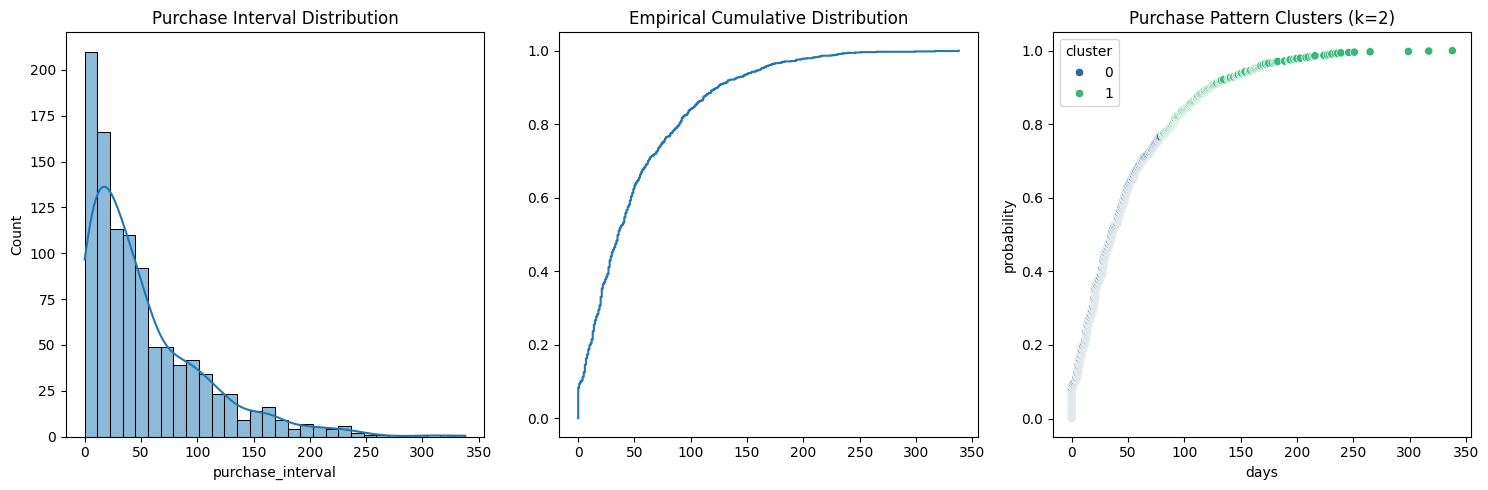

Identified 2 purchase pattern clusters
Cluster characteristics:
         count        mean        std   min   25%    50%    75%    max
cluster                                                               
0        791.0        -inf        NaN  -inf  10.0   25.0   44.0   79.0
1        241.0  130.688797  46.578592  81.0  96.0  115.0  154.0  338.0


d:\anaconda\envs\cs-3202\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


In [ ]:
# Pipeline execution
tidy = preprocess_retail_data(data)
product_data = retail_see('85123A', tidy)  # Analyze specific product

if not product_data.empty:
    ecdf_results, cluster_count = analyze_purchase_patterns(product_data)
    
    if ecdf_results is not None:
        plot_purchase_analysis(product_data, ecdf_results, cluster_count)
        print(f"Identified {cluster_count} purchase pattern clusters")
        print("Cluster characteristics:")
        print(ecdf_results.groupby('cluster')['days'].describe())
